Дан датасет с информацией о клиентах взявших кредит в компании А. Датасет состоит из 3000 записей. колонка target показывает результат кредита (0 - проблемный, 1 - успешный). По данному датасету: 

1. Сделайте предварительный анализ данных. (EDA)
2. Создайте визуализации используя seaborn и matplotlib: графики зависимости, гистограммы, боксплот). Найдите параметр с самой большой корреляцией
3. Создайте модель по данному датасету. (можете использовать scikit или xgboost)
4. Сделайте простейшее веб-приложение, который будет принимать данные клиента и возвращать предсказание модели (используйте flask или fastapi. для деплоя можете использовать heroku (опционально))

Кандидат должен сдать jupyter notebook со всем ходом действий, репозиторий с кодом веб приложения и ссылку на сервис в heroku (если есть)

# Get the data

In [1]:
import pandas as pd
import numpy as np
import os

from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt

csv_path = os.path.join(os.getcwd(), '../raw_data', 'credit.csv')
      
data = pd.read_csv(csv_path)

data.head()

,birth_date,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,target
0,08/12/1988,316315800,96800000,tashkent_city,M,married,no_credit_now,114000000,1
1,13/07/1994,237064800,180000000,tashkent_city,M,married,no_credit_now,194483333,1
2,18/12/1988,248900000,350000000,tashkent_city,M,not_married,no_credit_now,237583333,1
3,11/07/1984,235973000,300000000,tashkent_city,M,married,no_credit_now,248283333,1
4,25/03/1991,452710700,700000000,andijan,M,married,no_credit_now,3819750000,1


# Preprocessing

In [2]:
# duplicates are investigated and removed
print('number of duplicated rows: ',data.duplicated().sum())
data = data.drop_duplicates()

number of duplicated rows:  1


In [3]:
# missing values are investigated
data.isnull().sum().sort_values(ascending=False)/len(data)

birth_date             0.0
credit_amount          0.0
salary_amount          0.0
region                 0.0
gender                 0.0
marital_status         0.0
credit_history         0.0
card_incomes_amount    0.0
target                 0.0
dtype: float64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3310 entries, 0 to 3310
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   birth_date           3310 non-null   object
 1   credit_amount        3310 non-null   int64 
 2   salary_amount        3310 non-null   int64 
 3   region               3310 non-null   object
 4   gender               3310 non-null   object
 5   marital_status       3310 non-null   object
 6   credit_history       3310 non-null   object
 7   card_incomes_amount  3310 non-null   object
 8   target               3310 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 258.6+ KB


# Exploratory Data Analysis

## Target

In [5]:
df = pd.DataFrame()
df['total_number'] = data.target.value_counts()
df['percentage']   = data.target.value_counts()/len(data)
print(df)

   total_number  percentage
1          2980    0.900302
0           330    0.099698


<AxesSubplot:xlabel='target', ylabel='count'>

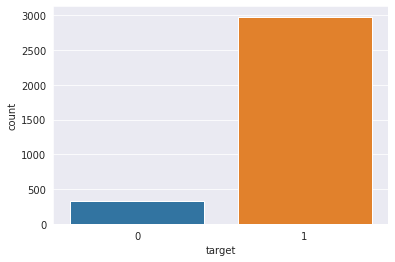

In [6]:
sns.set_style("darkgrid")
sns.countplot(data=data, x='target')

## Credit_amount

In [7]:
data.credit_amount.describe()

count    3.310000e+03
mean     4.257833e+08
std      2.229198e+08
min      4.090000e+07
25%      2.866357e+08
50%      4.106100e+08
75%      4.917285e+08
max      2.281500e+09
Name: credit_amount, dtype: float64

Outliers boundary: 812800000.0


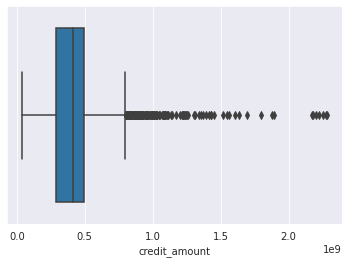

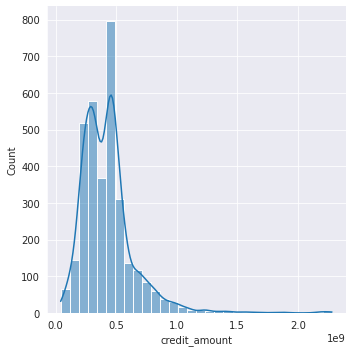

In [8]:
print('Outliers boundary:', data.credit_amount.quantile(0.95))
sns.boxplot(x=data.credit_amount)
sns.displot(data, x='credit_amount', kde=True, bins=30)

## Salary_amount

In [9]:
data.salary_amount.describe()

count    3.310000e+03
mean     2.642444e+08
std      2.053624e+08
min      4.000000e+05
25%      1.686875e+08
50%      2.300000e+08
75%      3.000000e+08
max      8.000000e+09
Name: salary_amount, dtype: float64

Outliers boundary: 500000000.0


(0.0, 1000000000.0)

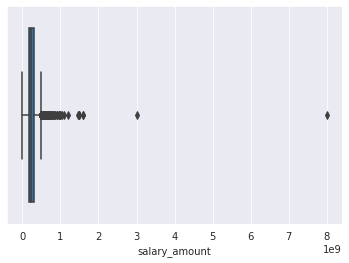

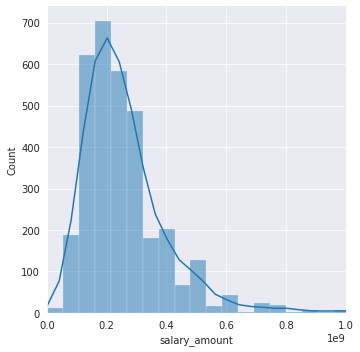

In [10]:
print('Outliers boundary:', data.salary_amount.quantile(0.95))
sns.boxplot(x=data["salary_amount"])
sns.displot(data, x='salary_amount', kde=True, bins=150)
plt.xlim(0, 1.0e9)

## Regions

In [11]:
df_region = data.region.value_counts().to_frame()
df_region

,region
tashkent_city,1732
tashkent,748
sirdarya,479
jizzakh,129
samarkand,49
qashqadaryo,40
surxondaryo,24
fergana,23
namangan,19
bukhara,16


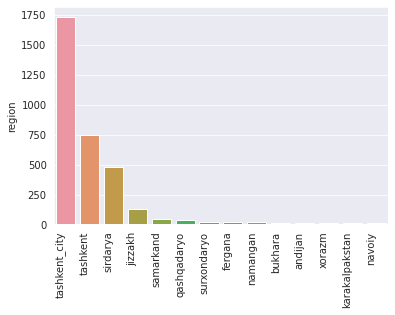

In [12]:
chart = sns.barplot(x=df_region.index, y=df_region.region)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.set_style("darkgrid")

## Gender

M    0.581571
F    0.418429
Name: gender, dtype: float64


<AxesSubplot:xlabel='gender', ylabel='count'>

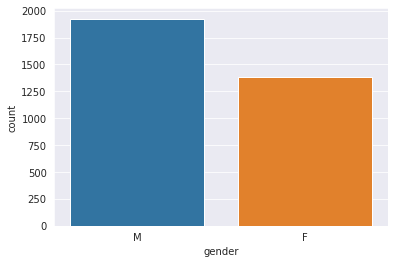

In [13]:
print(data.gender.value_counts()/len(data))
sns.countplot(data=data, x='gender')

## Marital_status

married        2695
not_married     391
divorced        132
widow            92
Name: marital_status, dtype: int64


<AxesSubplot:xlabel='marital_status', ylabel='count'>

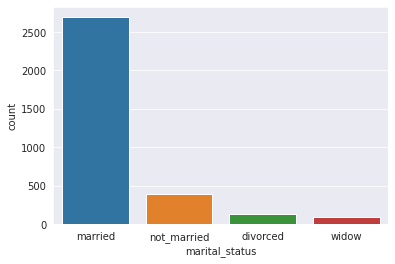

In [14]:
print(data.marital_status.value_counts())
sns.countplot(data=data, x='marital_status')

## Credit_history

no_credit_now     1788
has_credit_now    1522
Name: credit_history, dtype: int64


<AxesSubplot:xlabel='credit_history', ylabel='count'>

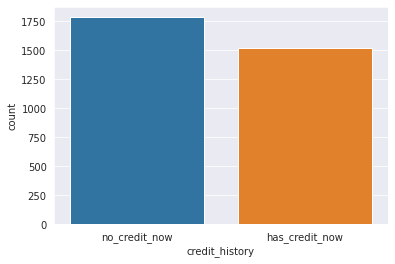

In [15]:
print(data.credit_history.value_counts())
sns.countplot(data=data, x='credit_history')

## Card_incomes_amount

In [16]:
# card_incomes_amount column converted to numbers
data.card_incomes_amount = data.card_incomes_amount.str.replace(',', '.').astype('float').astype('int64')
data.card_incomes_amount

0        114000000
1        194483333
2        237583333
3        248283333
4       3819750000
           ...    
3306     203833333
3307     161900000
3308     504333333
3309     165600000
3310     608400000
Name: card_incomes_amount, Length: 3310, dtype: int64

(0.0, 2000000000.0)

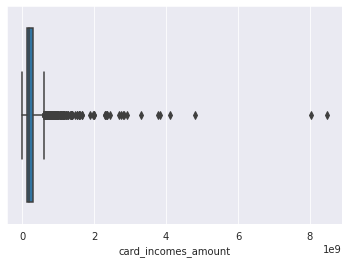

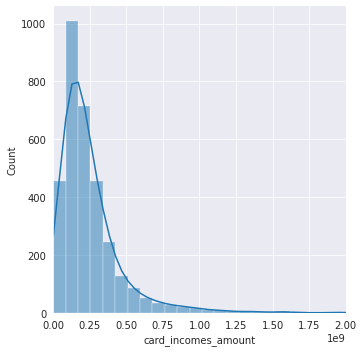

In [17]:
sns.boxplot(x=data["card_incomes_amount"])
sns.displot(data, x='card_incomes_amount', kde=True, bins=100)
plt.xlim(0, 2.0e9)

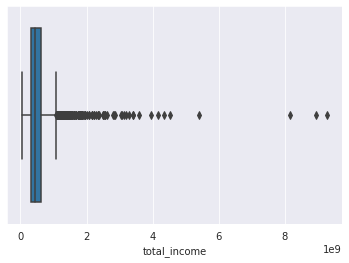

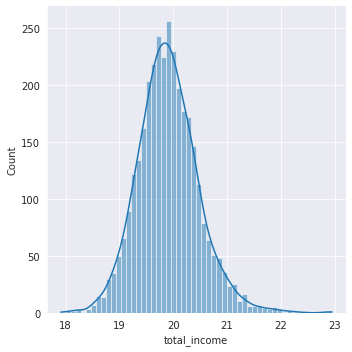

In [18]:
data['total_income'] = data['salary_amount'] + data['card_incomes_amount']

sns.boxplot(x=data["total_income"])
sns.displot(np.log(data.total_income), kde=True)
# plt.xlim(0, 2.0e9)

## Age (birth_date)

In [19]:
# Birth_date column converted to age for further analysis of credit holders' age
def age(born):
    born = datetime.strptime(born, "%d/%m/%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
  
data['age'] = data['birth_date'].apply(age)

data.drop(columns='birth_date', inplace=True)
data

,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,target,total_income,age
0,316315800,96800000,tashkent_city,M,married,no_credit_now,114000000,1,210800000,32
1,237064800,180000000,tashkent_city,M,married,no_credit_now,194483333,1,374483333,27
2,248900000,350000000,tashkent_city,M,not_married,no_credit_now,237583333,1,587583333,32
3,235973000,300000000,tashkent_city,M,married,no_credit_now,248283333,1,548283333,37
4,452710700,700000000,andijan,M,married,no_credit_now,3819750000,1,4519750000,30
...,...,...,...,...,...,...,...,...,...,...
3306,459650000,200000000,sirdarya,F,married,no_credit_now,203833333,1,403833333,41
3307,429042000,150000000,tashkent_city,M,married,no_credit_now,161900000,1,311900000,33
3308,318780000,280000000,tashkent_city,F,not_married,has_credit_now,504333333,1,784333333,48
3309,329709600,440000000,tashkent,M,married,has_credit_now,165600000,1,605600000,25


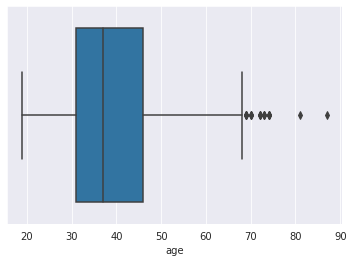

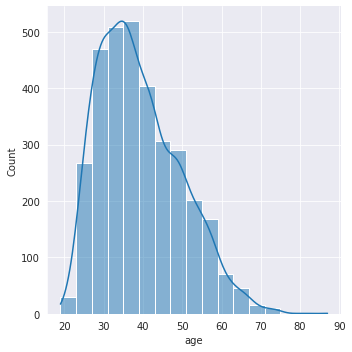

In [20]:
sns.boxplot(x=data["age"])
sns.displot(data, x='age', kde=True, bins=17)

In [21]:
data_copy = data.copy()

# Feature Engineering

In [22]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler = MinMaxScaler() # Instanciate RobustScaler

data['credit_amount'] = scaler.fit_transform(data[['credit_amount']]) # Use scaler to transform data
data['salary_amount'] = scaler.fit_transform(data[['salary_amount']]) # Use scaler to transform data
data['card_incomes_amount'] = scaler.fit_transform(data[['card_incomes_amount']]) # Use scaler to transform data
data['total_income'] = scaler.fit_transform(data[['total_income']])
data['age'] = scaler.fit_transform(data[['age']]) # Use scaler to transform data

In [23]:
from sklearn.preprocessing import OneHotEncoder

print(data.region.sort_values(ascending=True).unique())
print(data.marital_status.sort_values(ascending=True).unique())  # Check unique values

ohe = OneHotEncoder(sparse = False) # Instanciate encoder

# encode regions
region_encoded = ohe.fit_transform(data[['region']]) # Encode alley

data["andijan"], data['bukhara'], data['fergana'], data['jizzakh'], data['karakalpakstan'], \
data['namangan'], data['navoiy'], data['qashqadaryo'], data['samarkand'], data['sirdarya'], \
data['surxondaryo'], data['tashkent'], data['tashkent_city'], data['xorazm'] = region_encoded.T

# encode marital status
marital_status_encoded = ohe.fit_transform(data[['marital_status']]) # Encode marital status

data["divorced"],data["married"],data['not_married'],data['widow'] = marital_status_encoded.T

data.drop(columns='region', inplace=True)
data.drop(columns='marital_status', inplace=True)
data

['andijan' 'bukhara' 'fergana' 'jizzakh' 'karakalpakstan' 'namangan'
 'navoiy' 'qashqadaryo' 'samarkand' 'sirdarya' 'surxondaryo' 'tashkent'
 'tashkent_city' 'xorazm']
['divorced' 'married' 'not_married' 'widow']


,credit_amount,salary_amount,gender,credit_history,card_incomes_amount,target,total_income,age,andijan,bukhara,...,samarkand,sirdarya,surxondaryo,tashkent,tashkent_city,xorazm,divorced,married,not_married,widow
0,0.122921,0.012051,M,no_credit_now,0.013454,1,0.016368,0.191176,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.087550,0.022451,M,no_credit_now,0.022953,1,0.034134,0.117647,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.092832,0.043702,M,no_credit_now,0.028039,1,0.057264,0.191176,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.087063,0.037452,M,no_credit_now,0.029302,1,0.052998,0.264706,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.183795,0.087454,M,no_credit_now,0.450803,1,0.484060,0.161765,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0.186892,0.024951,F,no_credit_now,0.024056,1,0.037320,0.323529,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3307,0.173231,0.018701,M,no_credit_now,0.019107,1,0.027341,0.205882,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3308,0.124020,0.034952,F,has_credit_now,0.059521,1,0.078619,0.426471,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3309,0.128898,0.054953,M,has_credit_now,0.019544,1,0.059219,0.088235,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
from sklearn.preprocessing import OneHotEncoder

print(data.gender.sort_values(ascending=True).unique())
print(data.credit_history.sort_values(ascending=True).unique())  # Check unique values for credit history

binary_encoder = OneHotEncoder(sparse=False, drop='first') # Instanciate encoder

# encoding gender and credit history
data['M'], data["no_credit_now"] = binary_encoder.fit_transform(data[['gender', 'credit_history']]).T

data.drop(columns='gender', inplace=True)
data.drop(columns='credit_history', inplace=True)
data


['F' 'M']
['has_credit_now' 'no_credit_now']


,credit_amount,salary_amount,card_incomes_amount,target,total_income,age,andijan,bukhara,fergana,jizzakh,...,surxondaryo,tashkent,tashkent_city,xorazm,divorced,married,not_married,widow,M,no_credit_now
0,0.122921,0.012051,0.013454,1,0.016368,0.191176,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.087550,0.022451,0.022953,1,0.034134,0.117647,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.092832,0.043702,0.028039,1,0.057264,0.191176,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.087063,0.037452,0.029302,1,0.052998,0.264706,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.183795,0.087454,0.450803,1,0.484060,0.161765,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0.186892,0.024951,0.024056,1,0.037320,0.323529,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3307,0.173231,0.018701,0.019107,1,0.027341,0.205882,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3308,0.124020,0.034952,0.059521,1,0.078619,0.426471,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3309,0.128898,0.054953,0.019544,1,0.059219,0.088235,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Correlation

In [25]:
success = data[data['target']==1]
failure = data[data['target']==0]
print(success.shape, failure.shape)
success_sample = success.sample(n=330)

(2980, 26) (330, 26)


In [26]:
# data = pd.concat([success_sample, failure], axis=0)
# data

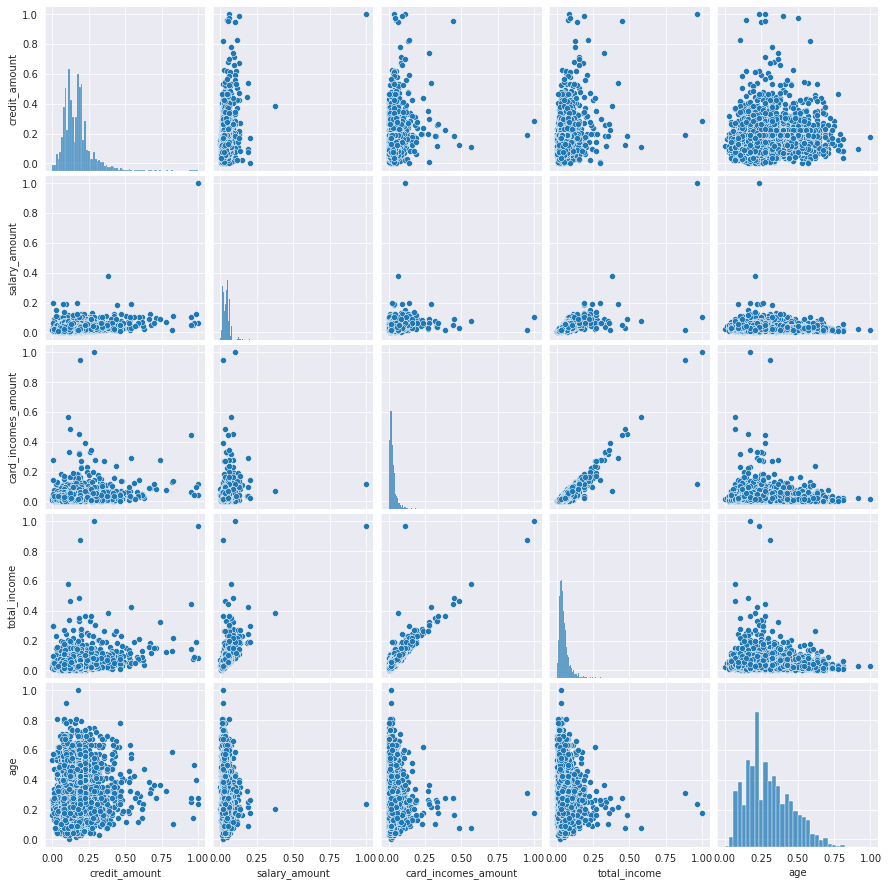

In [27]:
df = data[['credit_amount', 'salary_amount', 'card_incomes_amount', 'total_income', 'age']]
sns.pairplot(df)

# Collinearity

<AxesSubplot:>

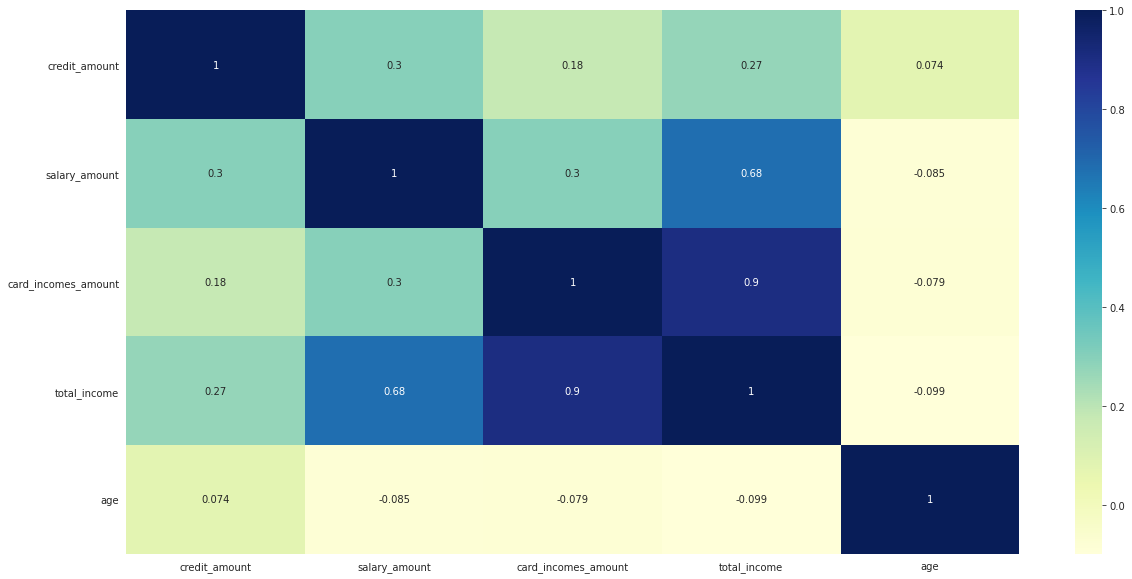

In [28]:
# Heatmap
# correlation is investigated only among numercial values (not categorical)
df = data[['credit_amount', 'salary_amount', 'card_incomes_amount', 'total_income', 'age']]

corr = df.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns,
            annot=True,
            cmap= "YlGnBu")

In [29]:
# table with feature correlation
corr_df = corr.unstack().reset_index() # Unstack correlation matrix
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df

,feature_1,feature_2,correlation
13,card_incomes_amount,total_income,0.903223
17,total_income,card_incomes_amount,0.903223
8,salary_amount,total_income,0.678990
16,total_income,salary_amount,0.678990
7,salary_amount,card_incomes_amount,0.298205
11,card_incomes_amount,salary_amount,0.298205
1,credit_amount,salary_amount,0.296111
5,salary_amount,credit_amount,0.296111
3,credit_amount,total_income,0.271373
15,total_income,credit_amount,0.271373


In [30]:
# identification of higly correlated features
correlated_features = pd.concat([corr_df[corr_df['correlation']>0.5], corr_df[corr_df['correlation']<-0.5]])
correlated_features

,feature_1,feature_2,correlation
13,card_incomes_amount,total_income,0.903223
17,total_income,card_incomes_amount,0.903223
8,salary_amount,total_income,0.678990
16,total_income,salary_amount,0.678990


In [31]:
# since total income is derived from card_incomes amount and salary_amount, these columns are highly correlated with
# total_income column. That's why card_incomes_amount and salary_amount can be dropped

data.drop(columns=['card_incomes_amount','salary_amount'], inplace=True)
data.head()

,credit_amount,target,total_income,age,andijan,bukhara,fergana,jizzakh,karakalpakstan,namangan,...,surxondaryo,tashkent,tashkent_city,xorazm,divorced,married,not_married,widow,M,no_credit_now
0,0.122921,1,0.016368,0.191176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.087550,1,0.034134,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.092832,1,0.057264,0.191176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.087063,1,0.052998,0.264706,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.183795,1,0.484060,0.161765,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


# Basemodel

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

X = data.drop(columns=['target'])
y = data['target']

model = LogisticRegression()

scores = cross_val_score(model, X, y, cv=10)

base_model_score = scores.mean()

base_model_score

0.9003021148036255

# Feature selection

## Permutation importance

In [33]:
# import numpy as np
# from sklearn.inspection import permutation_importance

# model = model.fit(X, y) # Fit model

# permutation_score = permutation_importance(model, X, y, n_repeats=100) # Perform Permutation

# importance_df = pd.DataFrame(np.vstack((X.columns,
#                                         permutation_score.importances_mean)).T) # Unstack results

# importance_df.columns=['feature','feature importance']

# importance_df.sort_values(by="feature importance", ascending = False) # Order by importance

## Drop less important features and cross validate

In [34]:
# X = data[importance_df.loc[importance_df['feature importance']>1e-3,'feature'].tolist()]

# model = RandomForestClassifier()

# scores = cross_val_score(model, X, y, cv=10)

# strong_model_score = scores.mean()

# strong_model_score

# Train and predict

## Split data set to train and test data sets

In [35]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=2)

## Model fit

In [36]:
# fit model no training data
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Model predict

In [37]:
# make predictions for test data
y_pred = model.predict(X_test)

## Evaluate accuracy

In [38]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 90.03%
Precision: 90.03%
Recall: 100.00%
F1 Score: 94.75%


In [39]:
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": y_pred})#Store results in dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix

predicted,1
actual,
0,66
1,596


In [40]:
from sklearn.metrics import roc_auc_score

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.5

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Impute then Scale for numerical variables: 
num_transformer = Pipeline([
    ('scaler', MinMaxScaler())])

# Encode categorical variables
cat_transformer = OneHotEncoder(sparse='False', handle_unknown='ignore')

# Encode binary variables
bin_transformer = OneHotEncoder(sparse=False, drop='first')

# Paralellize "num_transformer" and "One hot encoder"
preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, ['credit_amount', 'total_income', 'age']),
    ('cat_tr', cat_transformer, ['region', 'marital_status']),
    ('bin_tr', bin_transformer, ['gender', 'credit_history'])])

In [42]:
data_copy

,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,target,total_income,age
0,316315800,96800000,tashkent_city,M,married,no_credit_now,114000000,1,210800000,32
1,237064800,180000000,tashkent_city,M,married,no_credit_now,194483333,1,374483333,27
2,248900000,350000000,tashkent_city,M,not_married,no_credit_now,237583333,1,587583333,32
3,235973000,300000000,tashkent_city,M,married,no_credit_now,248283333,1,548283333,37
4,452710700,700000000,andijan,M,married,no_credit_now,3819750000,1,4519750000,30
...,...,...,...,...,...,...,...,...,...,...
3306,459650000,200000000,sirdarya,F,married,no_credit_now,203833333,1,403833333,41
3307,429042000,150000000,tashkent_city,M,married,no_credit_now,161900000,1,311900000,33
3308,318780000,280000000,tashkent_city,F,not_married,has_credit_now,504333333,1,784333333,48
3309,329709600,440000000,tashkent,M,married,has_credit_now,165600000,1,605600000,25


In [43]:
X = data_copy.drop(columns=['target'])
y = data_copy['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=2)

In [44]:
X_train_transformer = preprocessor.fit_transform(X_train)
display(X_train)
display(pd.DataFrame(X_train_transformer))

,credit_amount,salary_amount,region,gender,marital_status,credit_history,card_incomes_amount,total_income,age
2770,425700000,230000000,sirdarya,M,married,no_credit_now,157033333,387033333,36
1027,313467000,250000000,tashkent_city,F,married,has_credit_now,349933333,599933333,29
1885,346104000,400000000,tashkent_city,F,married,has_credit_now,208866667,608866667,50
119,289897600,250000000,tashkent_city,F,married,has_credit_now,127725000,377725000,42
3151,291456000,300000000,tashkent_city,M,not_married,has_credit_now,341583333,641583333,29
...,...,...,...,...,...,...,...,...,...
3205,250600000,100000000,tashkent_city,F,married,no_credit_now,101266667,201266667,29
2558,358248000,230000000,tashkent_city,M,not_married,has_credit_now,238666667,468666667,23
998,486350000,150000000,sirdarya,M,married,no_credit_now,56183333,206183333,49
1232,476400000,180000000,jizzakh,F,married,has_credit_now,177733333,357733333,32


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.171740,0.036738,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.121649,0.060654,0.147059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.136215,0.061657,0.455882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.111130,0.035692,0.338235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.111825,0.065333,0.147059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,0.093591,0.015869,0.147059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2644,0.141635,0.045908,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2645,0.198808,0.016422,0.441176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2646,0.194368,0.033446,0.191176,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
